## Import & GPU check & Path

In [54]:
from fastai import *
from fastai.vision import models, get_transforms, imagenet_stats, ImageImageList, ResizeMethod, MSELossFlat, unet_learner, NormType
from fastai.callback import *
from fastai.vision.gan import GANLearner
import torch
import pathlib
import os

In [55]:
import fastai
print(fastai.__version__)

1.0.61


In [56]:
#write pytorch version
print(torch.__version__)

1.9.0+cu111


In [57]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Laptop GPU'

In [58]:
#input
path_lr1 = pathlib.Path('C:/Users/grand/dev/internship2023/IN')
path_lr1

#output
path_hr1 = pathlib.Path('C:/Users/grand/dev/internship2023/OUT')
path_hr1

WindowsPath('C:/Users/grand/dev/internship2023/OUT')

In [59]:
len(os.listdir('C:/Users/grand/dev/internship2023/IN'))

1238

In [60]:
len(os.listdir('C:/Users/grand/dev/internship2023/OUT'))

1238

## Model & Batch size

In [61]:
bs,size = 32,256
arch = models.resnet34

## Prepare data

In [62]:
src = ImageImageList.from_folder(path_lr1).split_by_rand_pct(0.1, seed=42)

In [63]:
print(path_hr1)

C:\Users\grand\dev\internship2023\OUT


In [64]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr1/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True, resize_method=ResizeMethod.PAD, padding_mode='zeros')
           .databunch(bs=bs, num_workers=0).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data


In [65]:
data_gen = get_data(bs,size)

In [66]:
#data_gen.show_batch(4)

## Create Learner

In [67]:
wd = 1e-3

In [68]:
y_range = (-3.,3.)

In [69]:
loss_gen = MSELossFlat()

In [70]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [71]:
learn_gen = create_gen_learner()

## Learning

In [72]:
learn_gen.unfreeze()

In [73]:
learn_gen.data.batch_size = 16
learn_gen.fit_one_cycle(50, max_lr=1e-3, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.563237,0.280867,05:06
1,0.296043,0.178442,07:17
2,0.212186,0.154321,07:28
3,0.184145,0.145587,07:41
4,0.171408,0.142018,07:28
5,0.164733,0.139731,07:36
6,0.159947,0.135195,07:54
7,0.155924,0.133100,08:51
8,0.154343,0.129132,07:32
9,0.152821,0.129448,07:01


In [74]:
print(learn_gen.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

In [75]:
#print(learn_gen.recorder.lrs)


In [76]:
#print(learn_gen.recorder.losses)


## Additional training (optional)

In [77]:
#learn_gen.lr_find()

In [78]:
#learn_gen.unfreeze()

In [79]:
#learn_gen.data.batch_size = 8
#learn_gen.fit_one_cycle(5, slice(2e-5,wd/5))

## Curves

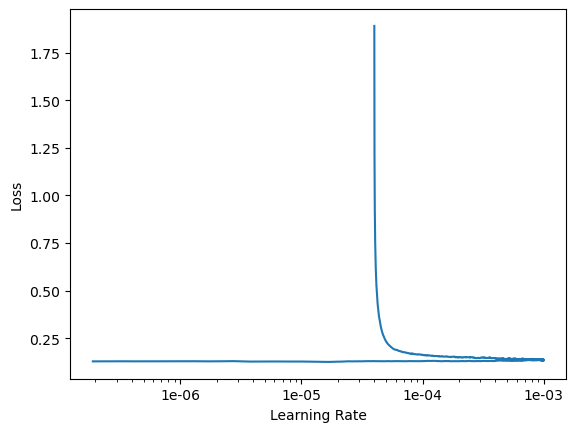

In [80]:
curve = learn_gen.recorder.plot(return_fig=True)

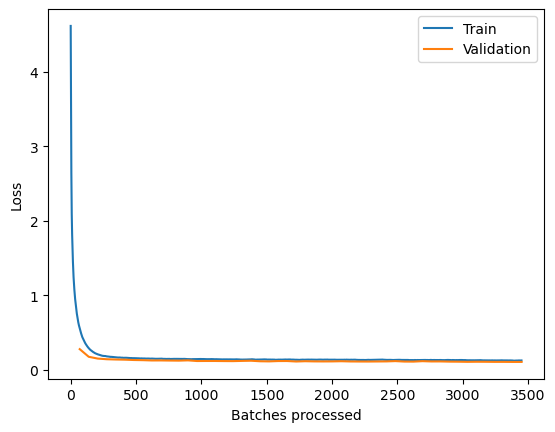

In [81]:
curve2 = learn_gen.recorder.plot_losses(return_fig=True)

## Save one plot

In [82]:
import csv

# Get the Axes object
ax = curve.axes[0]      ##############################CURVE

# Get the Line2D objects (the plotted lines) from the Axes
lines = ax.lines

# Loop through the lines and extract the data
for line in lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    print("x_data:", x_data)
    print("y_data:", y_data)

# Create a list of tuples with the x and y values
data = list(zip(x_data, y_data))

with open('C:/Users/grand/dev/internship2023/recorderPlot39.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Optionally, you can write a header row
    writer.writerow(['x_data', 'y_data'])

    # Write the data rows
    writer.writerows(data)

x_data: [4.003109e-05 4.003762e-05 4.004478e-05 4.005255e-05 ... 4.237243e-07 3.356437e-07 2.579213e-07 1.905586e-07]
y_data: [1.889802 1.815777 1.746644 1.682168 ... 0.128637 0.128933 0.128592 0.128475]


## Save two plots

In [83]:
import csv

# Get the Axes object
ax = curve2.axes[0]          ##############################CURVE2

# Get the Line2D objects (the plotted lines) from the Axes
lines = ax.lines

# Extract the data from the lines
data = []
for line in lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    data.append(list(zip(x_data, y_data)))

# Save the data to a CSV file
with open('C:/Users/grand/dev/internship2023/recorderPlotLosses39.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write a header row
    writer.writerow(['x_data_plot1', 'y_data_plot1', 'x_data_plot2', 'y_data_plot2'])

    # Write the data rows
    max_len = max(len(data[0]), len(data[1]))
    for i in range(max_len):
        row = []
        for plot_data in data:
            if i < len(plot_data):
                row.extend(plot_data[i])
            else:
                row.extend([None, None])
        writer.writerow(row)

## Show results

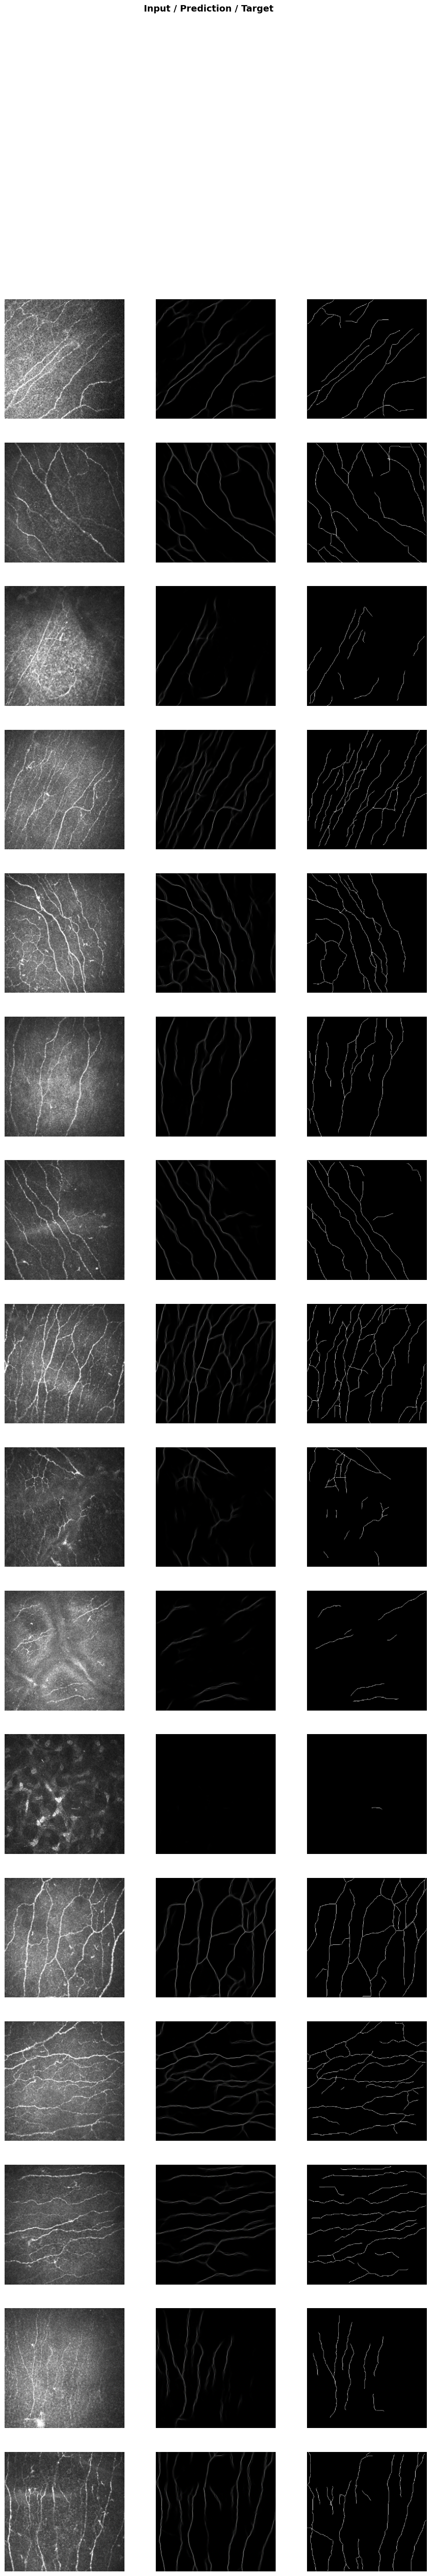

In [84]:
learn_gen.show_results(rows=100)

## Save model

In [85]:
learn_gen.path = pathlib.Path('C:/Users/grand/dev/internship2023/TRAINING/ForTraining3/FOR ARTICLE/INFERENCE/NEW_MODELS/34_1/U_net')

In [86]:
learn_gen.export('U-net-final')

In [87]:
learn_gen.save('U-net-final')

## Load model

In [88]:
learn_gen.path = pathlib.Path('C:/Users/grand/dev/internship2023/TRAINING/ForTraining3/FOR ARTICLE/INFERENCE/NEW_MODELS/34_1/U_net/')

In [89]:
learn_gen.load('U-net-final')

Learner(data=ImageDataBunch;

Train: LabelList (1115 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: C:\Users\grand\dev\internship2023\IN;

Valid: LabelList (123 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: C:\Users\grand\dev\internship2023\IN;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_

## New Inference

In [90]:
import glob, os
from fastai.vision import pil2tensor, open_image
import skimage
import numpy as np
import cv2
import re
import PIL
from PIL import Image 
from natsort import natsorted
from skimage import img_as_ubyte, filters
#from skimage.filters import unsharp_mask
from tqdm import tqdm

In [91]:
"""PATH_IN = 'C:/Users/grand/dev/internship2023/Inference/mosaicIN'

def numericalSort(value):
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts

numbers = re.compile(r'(\d+)')

for infile in sorted(glob.glob(PATH_IN + '*.png'), key = numericalSort):
    print("file : " + infile)

print(glob.glob(PATH_IN + '*.png'))

# glob all the png files inside PATH_IN
img_list = natsorted(glob.glob(PATH_IN + '/*.png'))
print(img_list)"""

'PATH_IN = \'C:/Users/grand/dev/internship2023/Inference/mosaicIN\'\n\ndef numericalSort(value):\n        parts = numbers.split(value)\n        parts[1::2] = map(int, parts[1::2])\n        return parts\n\nnumbers = re.compile(r\'(\\d+)\')\n\nfor infile in sorted(glob.glob(PATH_IN + \'*.png\'), key = numericalSort):\n    print("file : " + infile)\n\nprint(glob.glob(PATH_IN + \'*.png\'))\n\n# glob all the png files inside PATH_IN\nimg_list = natsorted(glob.glob(PATH_IN + \'/*.png\'))\nprint(img_list)'

In [92]:


def NNprocessing(PATH_IN, model, PATH_OUT):

    def numericalSort(value):
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts

    numbers = re.compile(r'(\d+)')

    k = 0
    minv_global = 1000;
    maxv_global = -1000;
    for infile in sorted(glob.glob(PATH_IN + '*.png'), key = numericalSort):
        file, ext = os.path.splitext(infile)
        with Image.open(infile) as im:

            pic = pil2tensor(im, np.float32)
            pic2 = torch.cat((pic, pic,pic), dim=0)
            pic3 = torch.div(pic, 255)

            inf = model.predict(open_image(infile))

            #Convert from Fast ai to numpy and convert the dimension
            inf_numpy = inf[2].numpy()
            inf_numpy = inf_numpy[0,:,:]

            minv = np.amin(inf_numpy)
            maxv = np.amax(inf_numpy)
            if minv < minv_global:
              minv_global = minv
            if maxv > maxv_global:
              maxv_global = maxv

            #Convert from numpy to Pillow
            inf_numpy = (255 * (inf_numpy - minv_global) / (maxv_global - minv_global)).astype(np.uint8)
            im2 = PIL.Image.fromarray(inf_numpy)

            #Save mosaics
            #skimage.io.imsave(os.path.join(PATH_OUT, f'{k}.png'), im2)
            im2.save(PATH_OUT+'{0}.png'.format(k))
            k = k + 1

In [93]:
def generate_mosaic_images(imageIn, sizeInput, mosaicSize, step, directoryMosaicIn):

    MosaicCombinedSize = round(sizeInput/mosaicSize)*mosaicSize

    numOverlap = (MosaicCombinedSize - sizeInput)/step + 1
    if numOverlap != round(numOverlap):
        print("Error. Numoverlap should be integer")
    numOverlap = int(numOverlap)

    # Mosaic
    stack = np.zeros((MosaicCombinedSize, MosaicCombinedSize, numOverlap*numOverlap))

    k = 0
    for i in range(numOverlap):
        for j in range(numOverlap):
            im = np.zeros((MosaicCombinedSize, MosaicCombinedSize))
            im[i*step : sizeInput+i*step , j*step : sizeInput+j*step] = imageIn
            stack[:,:,k] = im
            k += 1

    mosaic = []
    numMosaic = MosaicCombinedSize // mosaicSize

    for k in range(numOverlap*numOverlap):
        mosaic.append(skimage.util.view_as_blocks(stack[:,:,k], (mosaicSize, mosaicSize)))

    n = 0
    for k in range(numOverlap*numOverlap):
        for ii in range(numMosaic):  # number of mosaic images
            for jj in range(numMosaic):
                img = mosaic[k][ii, jj, :, :]
                img = img / 255
                img_ubyte = img_as_ubyte(img)
                #mixed = np.concatenate((img_ubyte, img_ubyte), axis=1) # Should be commented for U-net
                rgbMosaic = np.stack((img_ubyte, img_ubyte, img_ubyte), axis=2)
                skimage.io.imsave(os.path.join(directoryMosaicIn, f'{n}.png'), rgbMosaic)
                n += 1

In [94]:
def merge_mosaic_images(directoryMosaicOut, directoryOut, sizeInput, mosaicSize, step):

    MosaicCombinedSize = round(sizeInput/mosaicSize)*mosaicSize

    numOverlap = (MosaicCombinedSize - sizeInput)/step + 1
    if numOverlap != round(numOverlap):
        print("Error. Numoverlap should be integer")
    numOverlap = int(numOverlap)

    sizeTotal = MosaicCombinedSize + step*(numOverlap - 1)
    numMosaic = MosaicCombinedSize // mosaicSize

    # Read images
    baseFileNamesIn = natsorted([f for f in os.listdir(directoryMosaicOut) if f.endswith('.png')])
    numberOfImageFilesIn = len(baseFileNamesIn)
    imageIn = np.zeros((mosaicSize, mosaicSize, numberOfImageFilesIn))

    for i in range(numberOfImageFilesIn):
        fullFileNameIn = os.path.join(directoryMosaicOut, baseFileNamesIn[i])
        temp = cv2.imread(fullFileNameIn, cv2.IMREAD_GRAYSCALE)
        imageIn[:,:,i] = temp[:, :mosaicSize]

    # Separate into mosaics
    mosaicOut = np.empty((numOverlap*numOverlap, numMosaic, numMosaic), dtype=object)

    for k in range(numOverlap*numOverlap):
        for ii in range(numMosaic):
            for jj in range(numMosaic):
                n = numMosaic*numMosaic*k + numMosaic*ii + jj
                mosaicOut[k, ii, jj] = imageIn[:,:,n]

    # Convert to stack of images
    imageOut = np.zeros((mosaicSize*numMosaic, mosaicSize*numMosaic, numOverlap*numOverlap))

    for k in range(numOverlap*numOverlap):
        imageOut[:,:,k] = np.block([[mosaicOut[k, ii, jj] for jj in range(numMosaic)] for ii in range(numMosaic)])

    # Sharpen all images
    #def unsharp_mask(image, kernel_size=(3, 3), sigma=2, amount=2.0, threshold=0):
    #    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    #    sharpened = float(amount + 1) * image - float(amount) * blurred
    #    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    #    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    #    sharpened = sharpened.round().astype(np.uint8)
    #    if threshold > 0:
    #        low_contrast_mask = np.absolute(image - blurred) < threshold
    #        np.copyto(sharpened, image, where=low_contrast_mask)
    #    return sharpened
    #imageOut_sharp = np.zeros((mosaicSize*numMosaic, mosaicSize*numMosaic, 25))

    # Sharpen all images
    #def sharpen_image(image, radius=1.0, amount=1.0):
        # Apply the unsharp mask
    #    result = filters.unsharp_mask(image, radius, amount)
        # Convert float image back to uint8
   #     result = img_as_ubyte(result)
   #     return result
    imageOut_sharp = np.zeros((mosaicSize*numMosaic, mosaicSize*numMosaic, numOverlap*numOverlap))
    for k in range(numOverlap*numOverlap):
        # Convert the image to floating point format between 0 and 1
        image_float = imageOut[:,:,k] / 255.0
        # Apply unsharp mask
        sharpened = filters.unsharp_mask(image_float, radius=1.0, amount=4.0)     #Set the Mask strength
        # Scale the image back to the range of np.uint8
        sharpened_scaled = np.clip(sharpened * 255, 0, 255).astype(np.uint8)
        imageOut_sharp[:,:,k] = sharpened_scaled


   # for k in range(25):
    #    sharpened = filters.unsharp_mask(imageOut[:,:,k], radius=1.0, amount=1.0)
   #     print(np.max(imageOut[:,:,k]))
        # Normalize the data to 0-1 range
    #    sharpened_normalized = (sharpened - np.min(sharpened)) / (np.max(sharpened) - np.min(sharpened))
        # Scale the data to the range 0-255 and convert to uint8
    #    sharpened_scaled = (sharpened_normalized * 255).astype(np.uint8)
   #     imageOut_sharp[:,:,k] = sharpened_scaled
        #imageOut_sharp[:,:,k] = img_as_ubyte(imageOut_sharp[:,:,k])
        #imageOut_sharp[:,:,k] = unsharp_mask(imageOut[:,:,k])

    # Align stack of images
    im = np.zeros((sizeTotal, sizeTotal, numOverlap*numOverlap))
    for ii in range(numOverlap):
        for jj in range(numOverlap):
            k = numOverlap*ii + jj
            corner = (sizeTotal - MosaicCombinedSize) // 2
            start_x = corner - (ii - (numOverlap - 1)//2)*step
            end_x = min(start_x + MosaicCombinedSize, sizeTotal)
            start_y = corner - (jj - (numOverlap - 1)//2)*step
            end_y = min(start_y + MosaicCombinedSize, sizeTotal)
            # Trim imageOut if necessary
            #trimmed_imageOut = imageOut_sharp[:end_x-start_x, :end_y-start_y, k]
            #im[start_x:end_x, start_y:end_y, k] = trimmed_imageOut
            im[start_x:end_x, start_y:end_y, k] = imageOut_sharp[:,:,k]

    # Remove the outlier frames (> 3 STD from the mean)
    mean_im = np.mean(im, axis=(0,1))
    outliers = np.abs(mean_im - np.mean(mean_im)) > 3 * np.std(mean_im)
    im = im[:,:,~outliers]

    return im

In [95]:
#directoryMosaicIn = 'C:/Users/grand/dev/internship2023/Inference/mosaicIN'
#directoryMosaicOut = 'C:/Users/grand/dev/internship2023/Inference/mosaicOUT'
#NNprocessing(directoryMosaicIn, learn_gen, directoryMosaicOut)

In [96]:
import glob, os
import skimage
import numpy as np
import cv2
import re
from PIL import Image as ImagePIL
from natsort import natsorted
from skimage import img_as_ubyte, filters
#from skimage.filters import unsharp_mask
from tqdm import tqdm

directoryIn = 'C:/Users/grand/dev/internship2023/Inference/IN'
directoryMosaicIn = 'C:/Users/grand/dev/internship2023/Inference/mosaicIN\\'
directoryMosaicOut = 'C:/Users/grand/dev/internship2023/Inference/mosaicOUT\\'
directoryOut = 'C:/Users/grand/dev/internship2023/Inference/OUT'


# Get all .png files in directoryIn and its subdirectories
baseFileNamesIn = [os.path.join(root, name)
                   for root, dirs, files in os.walk(directoryIn)
                   for name in files
                   if name.endswith((".png"))]

# Process all images
for fullFileNameIn in tqdm(baseFileNamesIn, desc="Processing images"):
    imageIn = skimage.io.imread(fullFileNameIn)
    sizeInput = imageIn.shape[0]
    #imageIn1 = imageIn[:,:sizeInput,0]
    #imageIn2 = imageIn[:,sizeInput:2*sizeInput,0]  # input

    # Processing
    mosaicSize=256
    step = 8
    generate_mosaic_images(imageIn, sizeInput, mosaicSize, step, directoryMosaicIn)
    NNprocessing(directoryMosaicIn, learn_gen, directoryMosaicOut)
    im = merge_mosaic_images(directoryMosaicOut, directoryOut, sizeInput, mosaicSize, step)

    # Average overlapping sub-images
    img = np.mean(im, axis=2) / 255.0
    # Crop the central sizeInput portion
    height, width = img.shape
    start_row = height//2 -sizeInput//2
    start_col = width//2 - sizeInput//2
    img_cropped = img[start_row:start_row+sizeInput, start_col:start_col+sizeInput]

    RGBout = np.stack([img_cropped, img_cropped, img_cropped], axis=2)
    RGBout = img_as_ubyte(RGBout)  # Convert image data to uint8

    # Create corresponding output directory if it doesn't exist
    relPathIn = os.path.relpath(fullFileNameIn, directoryIn)
    fullFileNameOut = os.path.join(directoryOut, relPathIn)
    os.makedirs(os.path.dirname(fullFileNameOut), exist_ok=True)

    cv2.imwrite(fullFileNameOut, RGBout)

Processing images:   0%|          | 0/152 [00:00<?, ?it/s]

Processing images: 100%|██████████| 152/152 [4:31:55<00:00, 107.34s/it]  
